In [20]:
import os
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt

In [21]:
def process_power_per_pod(folder_path):
    # Process power consumption data
    power_file = os.path.join(folder_path, "metrics_energy.json")
    uid_pod_map_file = os.path.join(folder_path, "uid_pod_mapping.csv")  # Now reading as a CSV

    # Load UID to Pod Name Mapping
    if os.path.exists(uid_pod_map_file):
        uid_pod_map = pd.read_csv(uid_pod_map_file)  # Read CSV into a DataFrame
        # Ensure the mapping DataFrame has expected columns
        if not {"UID", "Pod Name"}.issubset(uid_pod_map.columns):
            print("Invalid UID-Pod mapping format")
            return pd.DataFrame()  # Return an empty DataFrame
    else: 
        print(f"No UID-Pod mapping file found in folder {folder_path}")
        return pd.DataFrame()  # Return an empty DataFrame

    # Load Power Data
    if os.path.exists(power_file):
        with open(power_file, 'r') as f:
            power_data = json.load(f)
    else:
        print("No power data file found")
        return pd.DataFrame()  # Return an empty DataFrame
       
    # Collect timestamps and values for each pod
    rows = []
    for uid_suffix, data in power_data.items():
        # Map UID suffix to pod name using the DataFrame
        pod_name_row = uid_pod_map[uid_pod_map["UID"].str.endswith(uid_suffix)]
        if pod_name_row.empty:
            continue  # Skip if no matching UID is found
        pod_name = pod_name_row.iloc[0]["Pod Name"]  # Get the first match

        # Append each entry in the pod's power data to the rows list
        for entry in data:
            rows.append({
                "timestamp": entry["timestamp"],
                "pod_name": pod_name,
                "value": entry["value"]
            })
    
    # Convert to DataFrame
    return pd.DataFrame(rows)

In [ ]:
def process_folder(folder_path):
    # Extract configuration from folder name
    folder_name = os.path.basename(folder_path)
    requested_mbps, duration, packet_length, cpu_limit, _, _ = folder_name.split('_')
    
    cpu_usages = []

    # Process iperf server log
    server_file = glob.glob(os.path.join(folder_path, "log_iperf_server_*.csv"))
    if server_file:
        server_file = server_file[0]
        df_server = pd.read_csv(server_file)
        
        # Calculate the average Mbps effectively received at server
        df_server['Mbps'] = df_server['Bitrate'] / 1e6  # Convert bps to Mbps
        avg_mbps_received = df_server['Mbps'].mean()
    else:
        avg_mbps_received = 0  # Default value if file not found
    
    # Process power consumption at node data
    power_file = os.path.join(folder_path, "metrics_host_energy.json")
    if os.path.exists(power_file):
        with open(power_file, 'r') as f:
            power_data = json.load(f)
        
        # Collect timestamps and values for CU container
        timestamps = []
        values = []
        for node_data in power_data.values():
            for entry in node_data:
                timestamps.append(entry['timestamp'])
                values.append(entry['value'])
        
        # Exclude first and last 20 seconds
        start_time = min(timestamps)
        end_time = max(timestamps)
        power_consumptions_host = [
            value for ts, value in zip(timestamps, values) 
            if (ts - start_time > 40) and (end_time - ts > 40)
        ]
        
        avg_power_consumption_host = sum(power_consumptions_host) / len(power_consumptions_host) if power_consumptions_host else 0
    else:
        avg_power_consumption_host = 0  # Default if no data found
    
    # Process pod-level power data using `process_power_per_pod`
    df_pod_power = process_power_per_pod(folder_path)
    
    # Initialize the power consumption variables for each pod type
    avg_power_oai_cu = 0
    avg_power_oai_du = 0
    avg_power_nr_ue = 0
    avg_power_upf = 0
    interval_to_exclude=20
    
    # Check if the column "pod_name" exists in the DataFrame
    if "pod_name" in df_pod_power.columns:
        # OAI-CU Pods
        oai_cu_pods = df_pod_power[df_pod_power["pod_name"].str.startswith("oai-cu")]
        if not oai_cu_pods.empty:
            oai_cu_pods_sorted = oai_cu_pods.sort_values(by="timestamp") # Sort by timestamp
            oai_cu_pods_filtered = oai_cu_pods_sorted.iloc[interval_to_exclude:-interval_to_exclude] # Exclude the first and last interval_to_exclude timestamps
            avg_power_oai_cu = oai_cu_pods_filtered["value"].mean() # Calculate the average power for the filtered data
        else:
            avg_power_oai_cu = 0  # Default if no data available

        # OAI-DU Pods
        oai_du_pods = df_pod_power[df_pod_power["pod_name"].str.startswith("oai-du")]
        if not oai_du_pods.empty:
            oai_du_pods_sorted = oai_du_pods.sort_values(by="timestamp")
            oai_du_pods_filtered = oai_du_pods_sorted.iloc[interval_to_exclude:-interval_to_exclude]
            avg_power_oai_du = oai_du_pods_filtered["value"].mean()
        else:
            avg_power_oai_du = 0  # Default if no data available

        # NR-UE Pods
        nr_ue_pods = df_pod_power[df_pod_power["pod_name"].str.startswith("oai-nr-ue")]
        if not nr_ue_pods.empty:
            nr_ue_pods_sorted = nr_ue_pods.sort_values(by="timestamp")
            nr_ue_pods_filtered = nr_ue_pods_sorted.iloc[interval_to_exclude:-interval_to_exclude]
            avg_power_nr_ue = nr_ue_pods_filtered["value"].mean()
        else:
            avg_power_nr_ue = 0  # Default if no data available

        # UPF Pods
        upf_pods = df_pod_power[df_pod_power["pod_name"].str.startswith("oai-upf")]
        if not upf_pods.empty:
            upf_pods_sorted = upf_pods.sort_values(by="timestamp")
            upf_pods_filtered = upf_pods_sorted.iloc[interval_to_exclude:-interval_to_exclude]
            avg_power_upf = upf_pods_filtered["value"].mean()
        else:
            avg_power_upf = 0  # Default if no data available
    else:
        # If "pod_name" column is missing, print a message or handle the error accordingly
        print(f"The column 'pod_name' is missing from the DataFrame at folder {folder_path}")
        avg_power_oai_cu = avg_power_oai_du = avg_power_nr_ue = avg_power_upf = 0


    
    # Process CPU usage data
    cpu_file = os.path.join(folder_path, "metrics_cpu.json")
    if os.path.exists(cpu_file):
        with open(cpu_file, 'r') as f:
            cpu_data = json.load(f)
        
        # Collect CPU values for CU container
        for pod_data in cpu_data.values():
            for entry in pod_data:
                cpu_usages.append(entry['value'])
        
        avg_cpu_usage = sum(cpu_usages) / len(cpu_usages) if cpu_usages else 0
    else:
        avg_cpu_usage = 0  # Default if no data found
    
    # Combine the results into a single row
    return {
        "cpu limit at cu": cpu_limit,
        "Mbps requested": int(requested_mbps),
        "packet length requested": int(packet_length),
        "avg Mbps effectively received at server": avg_mbps_received,
        "avg cu cpu usage [%]": avg_cpu_usage,
        "avg power consumption host [W]": avg_power_consumption_host,
        "avg CU power consumption [W]": avg_power_oai_cu,
        "avg DU power consumption [W]": avg_power_oai_du,
        "avg NR-UE power consumption [W]": avg_power_nr_ue,
        "avg UPF power consumption [W]": avg_power_upf
    }


In [23]:
def main(base_folder_path):
    data1 = []
    df_power_per_pod = pd.DataFrame()

    # Process each folder in the base directory
    for folder in os.listdir(base_folder_path):
        folder_path = os.path.join(base_folder_path, folder)
        if os.path.isdir(folder_path):
            row1 = process_folder(folder_path)
            df_pod = process_power_per_pod(folder_path)  # Call the updated function
            data1.append(row1)
            if not df_pod.empty:
                df_power_per_pod = pd.concat([df_power_per_pod, df_pod], ignore_index=True)

    # Combine folder-level data
    df = pd.DataFrame(data1)

    return df, df_power_per_pod
# Path to the base folder containing all experiment folders
base_folder_path = "/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/test_automation/data/exp7"
df, df_power_per_pod = main(base_folder_path)


In [24]:
base_folder_path_kube_baseline = "/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/test_automation/data/kube_baseline"
df_kube_baseline, df_power_per_pod_kube_baseline = main(base_folder_path_kube_baseline)
df_kube_baseline

,cpu limit at cu,Mbps requested,packet length requested,avg Mbps effectively received at server,avg cu cpu usage [%],avg power consumption host [W],avg CU power consumption [W],avg DU power consumption [W],avg NR-UE power consumption [W],avg UPF power consumption [W]
0,1mi,30,700,31.458137,0,3.910498,0.071367,0.615323,1.048569,0.147971
1,1mi,70,700,73.348866,0,4.391301,0.136831,0.613716,1.407284,0.279865
2,1mi,60,700,62.819523,0,4.052737,0.114741,0.594209,1.294014,0.235866
3,1mi,40,700,41.943498,0,3.978340,0.073042,0.576220,1.032672,0.165894
4,1mi,20,700,20.971819,0,2.850126,0.047879,0.496896,0.733651,0.095322
5,1mi,10,700,10.485962,0,3.554920,0.024725,0.517218,0.667923,0.054630
6,1mi,50,700,52.430062,0,4.227607,0.099293,0.616996,1.243200,0.202627


In [25]:
# View the updated DataFrame
df_show = df[df['packet length requested'] == 700]
df_show = df_show[df_show['Mbps requested'] == 10]
df_show['cpu limit at cu'] = df_show['cpu limit at cu'].str.replace('mi', '').astype(int)
df_show = df_show.sort_values(by='cpu limit at cu')

df_show

,cpu limit at cu,Mbps requested,packet length requested,avg Mbps effectively received at server,avg cu cpu usage [%],avg power consumption host [W],avg CU power consumption [W],avg DU power consumption [W],avg NR-UE power consumption [W],avg UPF power consumption [W]
48,25,10,700,8.921783,100.044346,3.049850,0.011455,0.469739,0.275129,0.021016
76,50,10,700,10.479578,88.878337,3.612064,0.025344,0.529668,0.332260,0.027801
23,75,10,700,10.484451,53.393479,3.541406,0.024770,0.512629,0.328232,0.026997
35,100,10,700,10.483306,45.068467,3.444387,0.022940,0.511147,0.319391,0.027243
50,125,10,700,10.485913,36.009962,3.503553,0.023759,0.526173,0.330541,0.027050
22,150,10,700,10.485833,30.232825,3.444822,0.023184,0.501862,0.311935,0.027265
21,175,10,700,10.486076,26.213918,3.372930,0.024256,0.476138,0.307726,0.026802
75,200,10,700,10.486018,19.949815,3.473492,0.025680,0.523510,0.327865,0.027256
15,500,10,700,10.485987,6.605360,3.521521,0.025475,0.530096,0.325388,0.027311
31,1000,10,700,10.486029,4.603982,3.515779,0.024975,0.524701,0.654075,0.052613


# Power consumption vertical vs horizontal

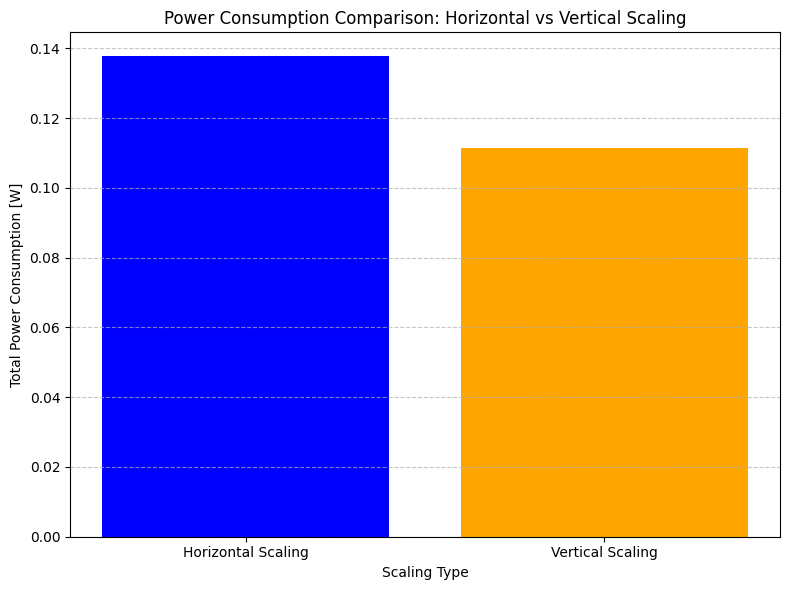

In [26]:
# Filter data for CPU limit = 1000
df_show = df[df['packet length requested'] == 700]
df_filtered = df_show[df_show['cpu limit at cu'].str.replace('mi', '').astype(int) == 125]

# Aggregate horizontal scaling (30 Mbps + 40 Mbps)
horizontal_scaling = df_filtered[df_filtered["Mbps requested"] == 30]["avg CU power consumption [W]"].iloc[0] *2
# Filter data for CPU limit = 1000
df_show = df[df['packet length requested'] == 700]
df_filtered = df_show[df_show['cpu limit at cu'].str.replace('mi', '').astype(int) == 175]
# Vertical scaling (70 Mbps)
vertical_scaling = df_filtered[df_filtered["Mbps requested"] == 60]["avg CU power consumption [W]"].iloc[0]

# Plot the results
plt.figure(figsize=(8, 6))
scaling_types = ["Horizontal Scaling", "Vertical Scaling"]
energy_values = [horizontal_scaling, vertical_scaling]
plt.bar(scaling_types, energy_values, color=['blue', 'orange'])

plt.title("Power Consumption Comparison: Horizontal vs Vertical Scaling")
plt.ylabel("Total Power Consumption [W]")
plt.xlabel("Scaling Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


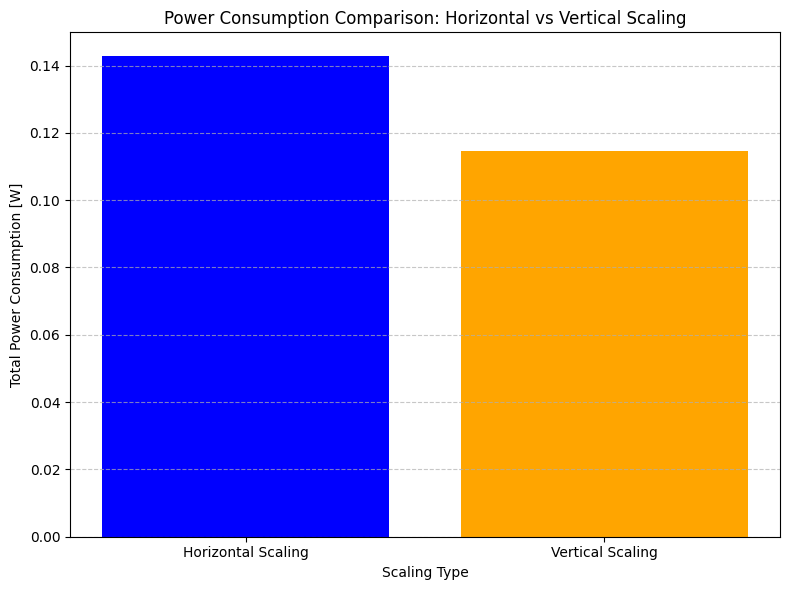

In [27]:
# Filter data for CPU limit = 1000
df_show = df_kube_baseline[df_kube_baseline['packet length requested'] == 700]
df_filtered = df_show[df_show['cpu limit at cu'].str.replace('mi', '').astype(int) == 1]

# Aggregate horizontal scaling (30 Mbps + 40 Mbps)
horizontal_scaling = df_filtered[df_filtered["Mbps requested"] == 30]["avg CU power consumption [W]"].iloc[0] *2
# Filter data for CPU limit = 1000
df_show = df_kube_baseline[df_kube_baseline['packet length requested'] == 700]
df_filtered = df_show[df_show['cpu limit at cu'].str.replace('mi', '').astype(int) == 1]
# Vertical scaling (70 Mbps)
vertical_scaling = df_filtered[df_filtered["Mbps requested"] == 60]["avg CU power consumption [W]"].iloc[0]

# Plot the results
plt.figure(figsize=(8, 6))
scaling_types = ["Horizontal Scaling", "Vertical Scaling"]
energy_values = [horizontal_scaling, vertical_scaling]
plt.bar(scaling_types, energy_values, color=['blue', 'orange'])

plt.title("Power Consumption Comparison: Horizontal vs Vertical Scaling")
plt.ylabel("Total Power Consumption [W]")
plt.xlabel("Scaling Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Power Consumption [W] over Requested Throughput [Mbps]

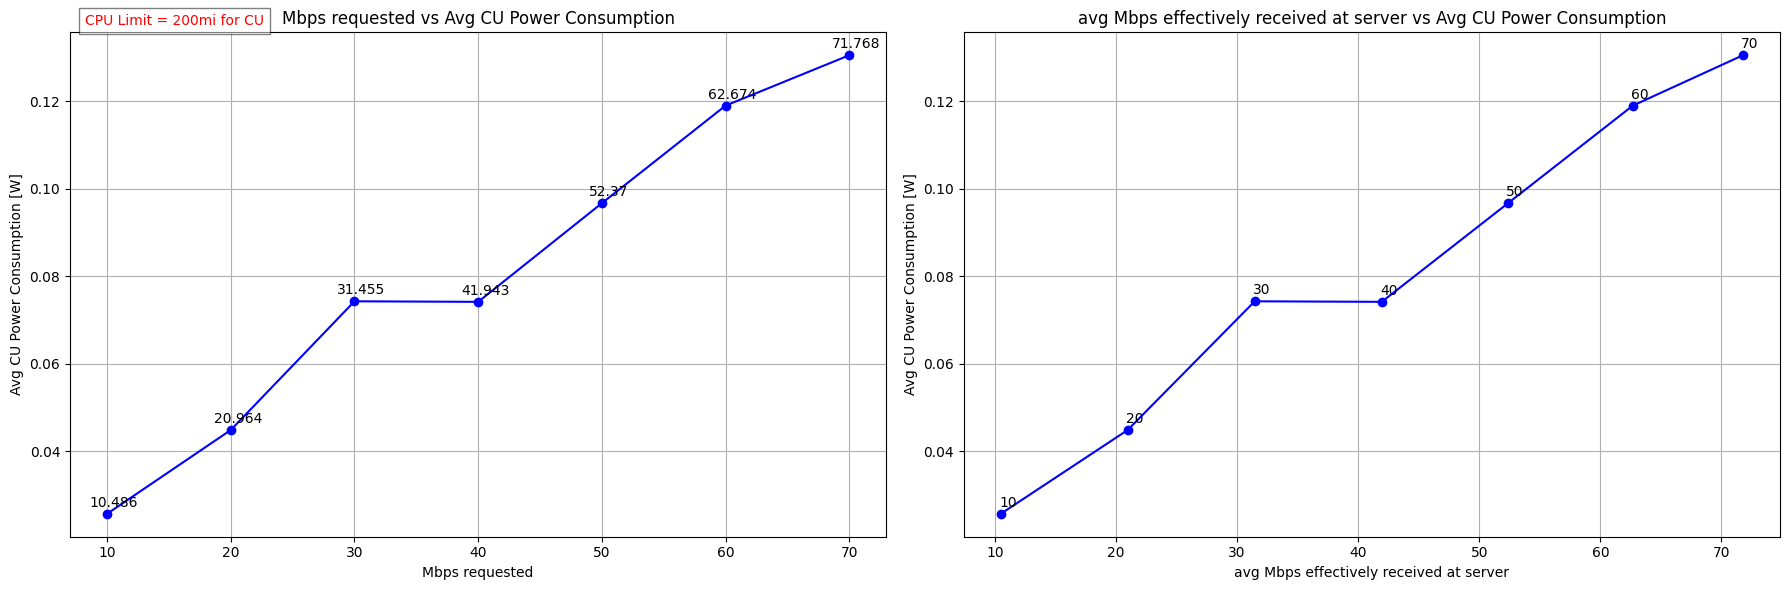

In [28]:

def plot_power_consumption_over_requested_throughput(cpu_limit):
    # Create the subplots: 1 row, 3 columns
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Adjusted size for horizontal layout

    # Plot 1: Mbps requested vs Avg CU Power Consumption (left)
    df_show = df[df['packet length requested'] == 700]
    df_show = df_show[df_show['cpu limit at cu'].str.replace('mi', '').astype(int) == cpu_limit]
    df_show = df_show.sort_values(by='Mbps requested')

    axes[0].plot(df_show["Mbps requested"], df_show["avg CU power consumption [W]"], marker='o', linestyle='-', color='b')
    axes[0].set_ylabel("Avg CU Power Consumption [W]")
    axes[0].set_xlabel("Mbps requested")
    axes[0].set_title("Mbps requested vs Avg CU Power Consumption")
    axes[0].grid(True)

    # Annotate points for Plot 1
    for i in range(len(df_show)):
        axes[0].annotate(f"{round(df_show['avg Mbps effectively received at server'].iloc[i], 3)}",
                        (df_show["Mbps requested"].iloc[i], df_show["avg CU power consumption [W]"].iloc[i]),
                        textcoords="offset points", xytext=(5, 5), ha='center')

    # Plot 2: avg Mbps effectively received at server vs Avg CU Power Consumption (middle)
    axes[1].plot(df_show["avg Mbps effectively received at server"], df_show["avg CU power consumption [W]"], marker='o', linestyle='-', color='b')
    axes[1].set_ylabel("Avg CU Power Consumption [W]")
    axes[1].set_xlabel("avg Mbps effectively received at server")
    axes[1].set_title("avg Mbps effectively received at server vs Avg CU Power Consumption")
    axes[1].grid(True)

    # Annotate points for Plot 2
    for i in range(len(df_show)):
        axes[1].annotate(f"{df_show['Mbps requested'].iloc[i]}",
                        (df_show["avg Mbps effectively received at server"].iloc[i], df_show["avg CU power consumption [W]"].iloc[i]),
                        textcoords="offset points", xytext=(5, 5), ha='center')

    # Add a label to indicate the fixed CPU limit for the first two plots (top left of first two plots)
    cpu_limit_fixed = df_show["cpu limit at cu"].iloc[0]  # Example value of the fixed CPU limit
    fig.text(
        0.05, 0.95,  # X and Y positions in axes coordinates (relative to the plot area)
        f"CPU Limit = {cpu_limit_fixed} for CU", 
        ha='left', fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.5)
    )

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

plot_power_consumption_over_requested_throughput(cpu_limit=200)

# CPU over Performances

cpu limit at cu                                  1mi
Mbps requested                                    20
packet length requested                          700
avg Mbps effectively received at server    20.971819
avg cu cpu usage [%]                               0
avg power consumption host [W]              2.850126
avg CU power consumption [W]                0.047879
avg DU power consumption [W]                0.496896
avg NR-UE power consumption [W]             0.733651
avg UPF power consumption [W]               0.095322
Name: 4, dtype: object


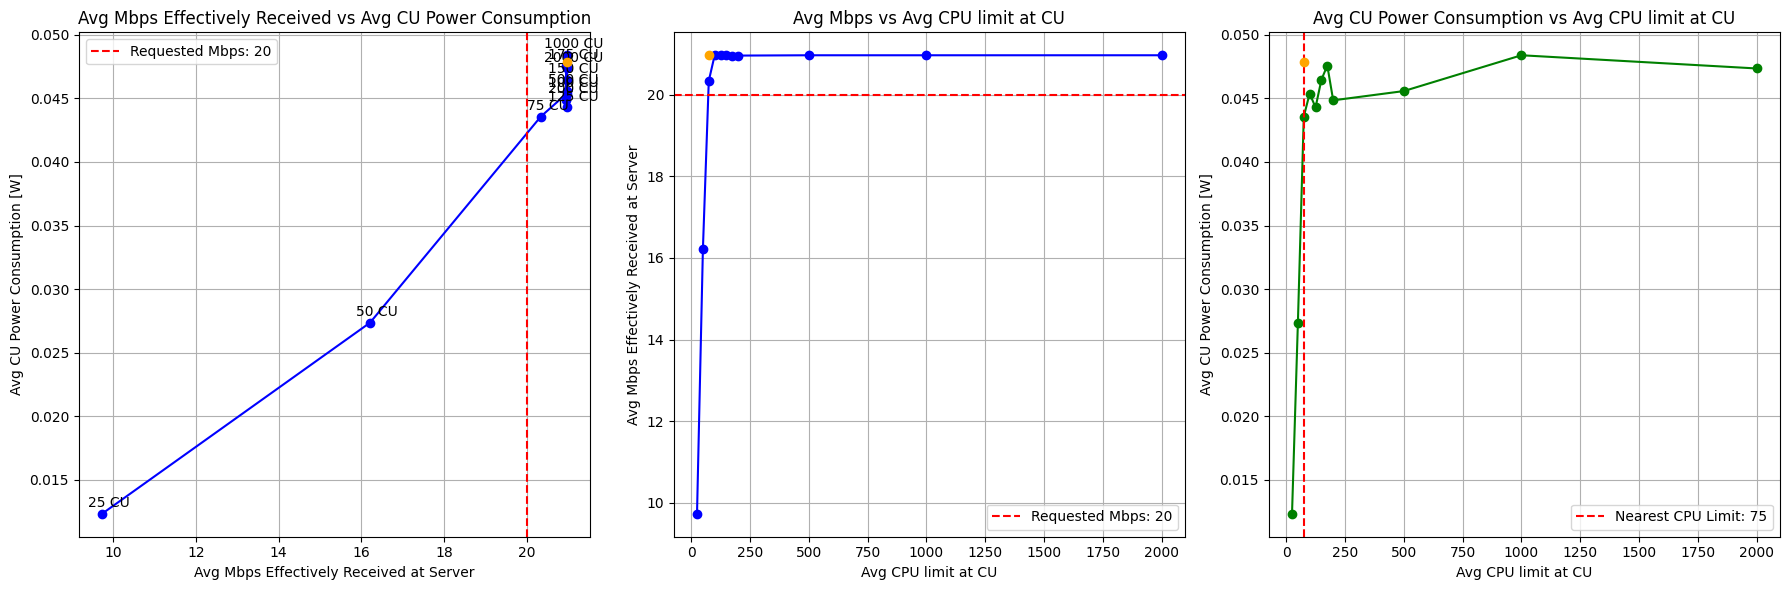

In [29]:
def plot_cpu_varying(mbps_requested):
    # Prepare the data
    df_show = df[df['packet length requested'] == 700]
    df_show = df_show[df_show['Mbps requested'] == mbps_requested]
    df_show['cpu limit at cu'] = df_show['cpu limit at cu'].str.replace('mi', '').astype(int)
    df_show = df_show.sort_values(by='cpu limit at cu')
    
    # Find the CPU limit nearest to the requested Mbps
    requested_mbps_fixed = mbps_requested  # Fixed requested Mbps
    nearest_cpu_limit_index = (df_show["avg Mbps effectively received at server"] - requested_mbps_fixed).abs().idxmin()
    nearest_cpu_limit = df_show.loc[nearest_cpu_limit_index, "cpu limit at cu"]

    # Extract corresponding values from the df_kube_baseline for the requested Mbps
    df_kube_baseline_show = df_kube_baseline[df_kube_baseline['Mbps requested'] == mbps_requested]
    
    # Assume the baseline data will have only one row for the requested Mbps, or take the first one if multiple
    if not df_kube_baseline_show.empty:
        baseline_row = df_kube_baseline_show.iloc[0]
        print(baseline_row)
        baseline_mbps_received = baseline_row['avg Mbps effectively received at server']
        baseline_power_consumption = baseline_row['avg CU power consumption [W]']
    else:
        baseline_mbps_received = baseline_power_consumption = None

    # Create subplots: 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjusted size for horizontal layout

    # Plot 1: Avg Mbps Effectively Received vs Avg CU Power Consumption (varying CPU limit)
    axes[0].plot(df_show["avg Mbps effectively received at server"], df_show["avg CU power consumption [W]"], 
                 marker='o', linestyle='-', color='b')
    axes[0].set_ylabel("Avg CU Power Consumption [W]")
    axes[0].set_xlabel("Avg Mbps Effectively Received at Server")
    axes[0].set_title("Avg Mbps Effectively Received vs Avg CU Power Consumption")
    axes[0].grid(True)

    # Annotate points for Plot 1
    for i in range(len(df_show)):
        axes[0].annotate(f"{df_show['cpu limit at cu'].iloc[i]} CU",
                         (df_show["avg Mbps effectively received at server"].iloc[i], 
                          df_show["avg CU power consumption [W]"].iloc[i]),
                         textcoords="offset points", xytext=(5, 5), ha='center')

    # Add a vertical line at the requested Mbps for Plot 1
    axes[0].axvline(x=requested_mbps_fixed, color='red', linestyle='--', linewidth=1.5, label=f"Requested Mbps: {requested_mbps_fixed}")
    axes[0].legend()

    # Plot 2: Avg Mbps Effectively Received vs CPU limit (Plot 2 from the original plot_cpu_limits)
    axes[1].plot(df_show["cpu limit at cu"], df_show["avg Mbps effectively received at server"], 
                 marker='o', linestyle='-', color='b')
    axes[1].set_ylabel("Avg Mbps Effectively Received at Server")
    axes[1].set_xlabel("Avg CPU limit at CU")
    axes[1].set_title("Avg Mbps vs Avg CPU limit at CU")
    axes[1].grid(True)

    # Add a horizontal line at the requested Mbps in Plot 2
    axes[1].axhline(y=requested_mbps_fixed, color='red', linestyle='--', linewidth=1.5, label=f"Requested Mbps: {requested_mbps_fixed}")
    axes[1].legend()

    # Plot 3: Avg CU Power Consumption vs CPU limit (Plot 3 from the original plot_cpu_limits)
    axes[2].plot(df_show["cpu limit at cu"], df_show["avg CU power consumption [W]"], 
                 marker='o', linestyle='-', color='g')
    axes[2].set_ylabel("Avg CU Power Consumption [W]")
    axes[2].set_xlabel("Avg CPU limit at CU")
    axes[2].set_title("Avg CU Power Consumption vs Avg CPU limit at CU")
    axes[2].grid(True)

    # Add a vertical line at the CPU limit nearest to the requested Mbps in Plot 3
    axes[2].axvline(x=nearest_cpu_limit, color='red', linestyle='--', linewidth=1.5, label=f"Nearest CPU Limit: {nearest_cpu_limit}")
    axes[2].legend()

    # If baseline values are available, plot them on each subplot as a point
    if baseline_mbps_received is not None and baseline_power_consumption is not None:
        axes[0].scatter(baseline_mbps_received, baseline_power_consumption, color='orange', zorder=5, label="Kubernetes Baseline")
        axes[1].scatter(nearest_cpu_limit,baseline_mbps_received, color='orange', zorder=5, label="Kubernetes Baseline")
        axes[2].scatter(nearest_cpu_limit, baseline_power_consumption, color='orange', zorder=5, label="Kubernetes Baseline")
        
    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the combined function for a specific value of Mbps requested
plot_cpu_varying(mbps_requested=20)


# Energy Spare and Energy Overspent

In [30]:
def calculate_power_spare_and_overspent(df_experiment):
    # Create an empty DataFrame to store results
    df_results = pd.DataFrame()
    df_experiment['cpu limit at cu'] = df_experiment['cpu limit at cu'].str.replace('mi', '').astype(int)

    # Iterate over groups based on Mbps requested
    for throughput, group in df_experiment.groupby('Mbps requested'):
        # Filter group to include only rows where throughput received satisfies the requested
        satisfying_group = group[
            abs(group['avg Mbps effectively received at server'] - throughput) <= (0.05 * throughput)  # Allow up to 5% deviation
        ]

        # Ensure there are at least two valid configurations
        if len(satisfying_group) < 2:
            continue

        # Sort satisfying configurations by CPU allocation (ascending)
        satisfying_group = satisfying_group.sort_values(by='cpu limit at cu')

        # Identify the optimized and next higher configurations
        optimized_row = satisfying_group.iloc[0]  # Configuration with the lowest CPU
        next_higher_row = satisfying_group.iloc[1]  # Configuration with the next higher CPU

        # Extract power consumption and CPU allocation values
        power_optimized = optimized_row['avg CU power consumption [W]']
        power_next_higher = next_higher_row['avg CU power consumption [W]']
        cpu_optimized = optimized_row['cpu limit at cu']
        cpu_next_higher = next_higher_row['cpu limit at cu']

        # Calculate Power Spare and Power Overspent
        power_spare = (abs(power_optimized - power_next_higher) / power_optimized) * 100
        power_overspent = (abs(power_optimized - power_next_higher) / power_next_higher) * 100

        # Append results
        df_results = pd.concat([df_results, pd.DataFrame({
            'Mbps requested': [throughput],
            'Power Optimized [W]': [power_optimized],
            'CPU Optimized [mi]': [cpu_optimized],
            'Power Next Higher [W]': [power_next_higher],
            'CPU Next Higher [mi]': [cpu_next_higher],
            'Power Spare [%]': [power_spare],
            'Power Overspent [%]': [power_overspent]
        })], ignore_index=True)

    return df_results

# Generate the results DataFrame
df_power_spare_and_overspent = calculate_power_spare_and_overspent(df)

# Display the results
df_power_spare_and_overspent


,Mbps requested,Power Optimized [W],CPU Optimized [mi],Power Next Higher [W],CPU Next Higher [mi],Power Spare [%],Power Overspent [%]
0,10,0.025344,50.0,0.024770,75.0,2.266222,2.318770
1,20,0.043568,75.0,0.045378,100.0,4.155866,3.990045
2,30,0.061562,100.0,0.068847,125.0,11.833607,10.581441
3,40,0.063294,125.0,0.073834,150.0,16.651943,14.274896
4,50,0.092723,150.0,0.096044,175.0,3.582191,3.458308
5,60,0.111364,175.0,0.119000,200.0,6.856673,6.416701
6,70,0.114611,175.0,0.130523,200.0,13.882880,12.190489


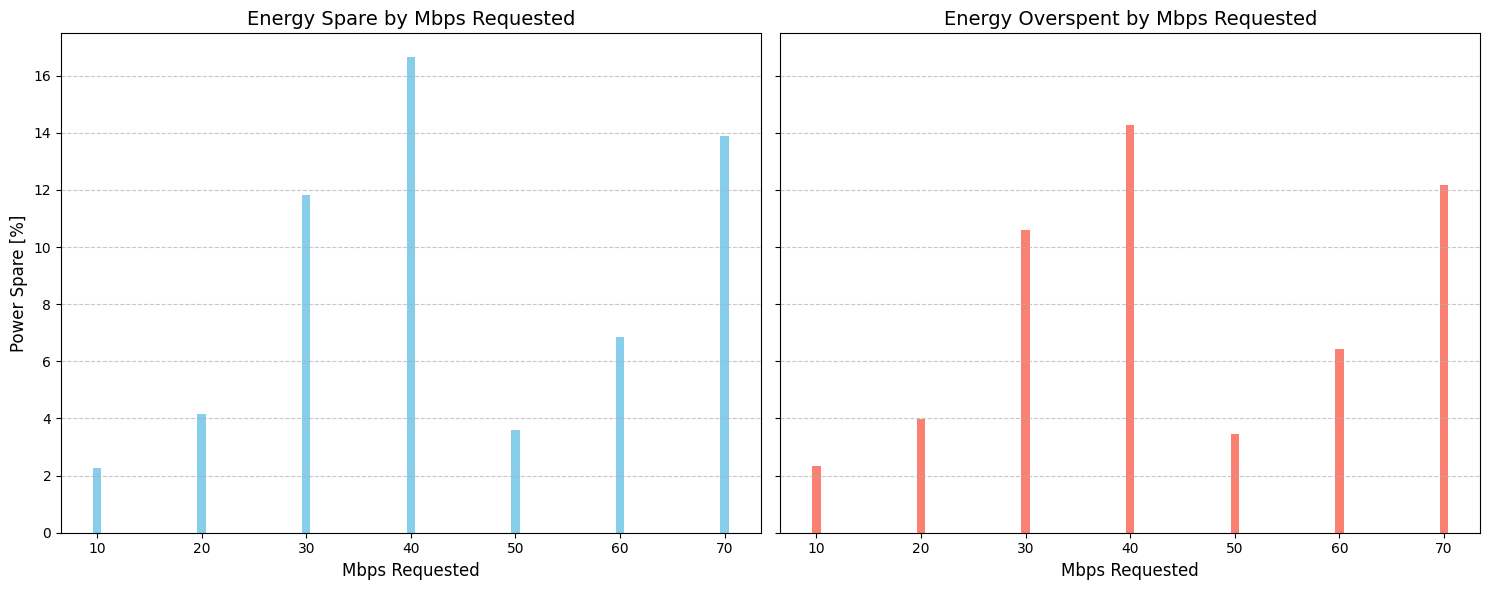

In [31]:
# Setting up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Bar plot for Power Spare
axes[0].bar(df_power_spare_and_overspent['Mbps requested'], df_power_spare_and_overspent['Power Spare [%]'], color='skyblue')
axes[0].set_title('Energy Spare by Mbps Requested', fontsize=14)
axes[0].set_xlabel('Mbps Requested', fontsize=12)
axes[0].set_ylabel('Power Spare [%]', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Bar plot for Power Overspent
axes[1].bar(df_power_spare_and_overspent['Mbps requested'], df_power_spare_and_overspent['Power Overspent [%]'], color='salmon')
axes[1].set_title('Energy Overspent by Mbps Requested', fontsize=14)
axes[1].set_xlabel('Mbps Requested', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


   Mbps requested  Power Optimized [W]  CPU Optimized [mi]  \
0              10             0.025344                50.0   
1              20             0.043568                75.0   
2              30             0.061562               100.0   
3              40             0.063294               125.0   
4              50             0.092723               150.0   
5              60             0.111364               175.0   
6              70             0.114611               175.0   

   Power Baseline [W]  Power Spare [%]  Power Overspent [%]  
0            0.024725         2.441426             2.502523  
1            0.047879         9.895942             9.004829  
2            0.071367        15.927454            13.739156  
3            0.073042        15.400517            13.345276  
4            0.099293         7.085360             6.616554  
5            0.114741         3.032392             2.943144  
6            0.136831        19.387037            16.238813  


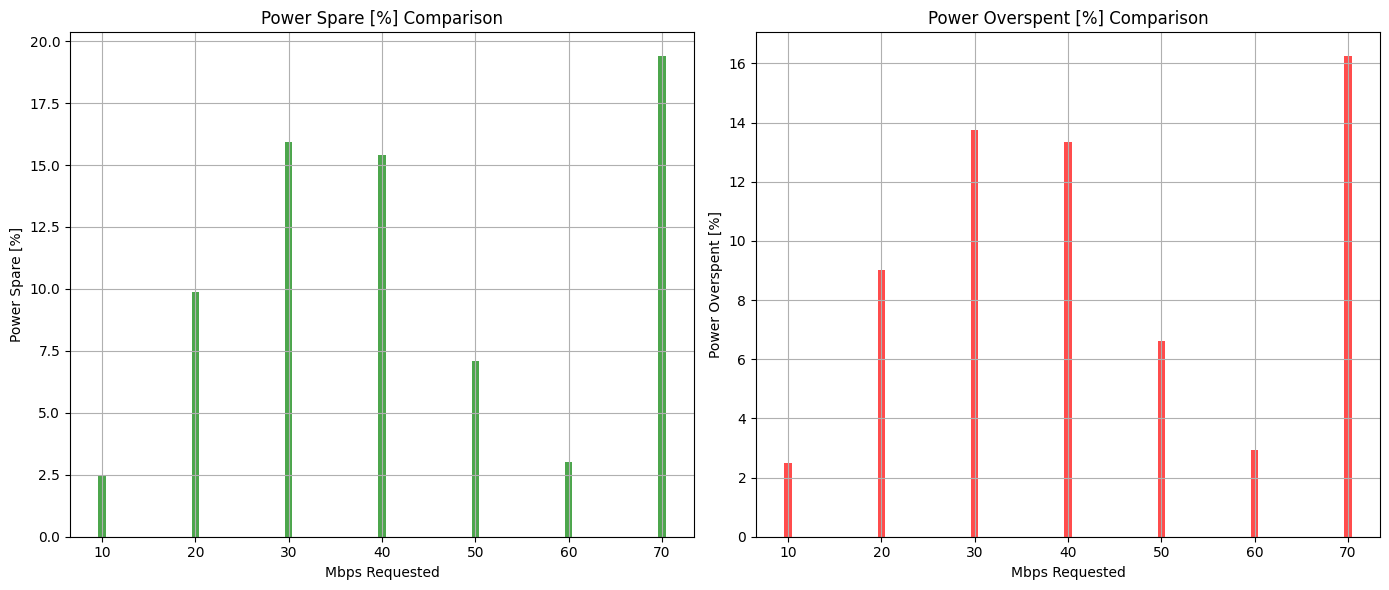

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_comparison_with_kube_baseline(df_experiment, df_kube_baseline):
    # Create an empty DataFrame to store results
    df_results = pd.DataFrame()
    
    # Iterate over groups based on Mbps requested
    for throughput, group in df_experiment.groupby('Mbps requested'):
        # Filter group to include only rows where throughput received satisfies the requested
        satisfying_group = group[
            abs(group['avg Mbps effectively received at server'] - throughput) <= (0.05 * throughput)  # Allow up to 5% deviation
        ]

        # Ensure there are at least two valid configurations
        if len(satisfying_group) < 2:
            continue

        # Sort satisfying configurations by CPU allocation (ascending)
        satisfying_group = satisfying_group.sort_values(by='cpu limit at cu')

        # Identify the optimized configuration (with the lowest CPU that satisfies performance)
        optimized_row = satisfying_group.iloc[0]  # Configuration with the lowest CPU
        
        # Extract power consumption and CPU allocation for the optimized configuration
        power_optimized = optimized_row['avg CU power consumption [W]']
        cpu_optimized = optimized_row['cpu limit at cu']

        # Extract the Kubernetes baseline for the corresponding CPU configuration
        baseline_row = df_kube_baseline[
            (df_kube_baseline['Mbps requested'] == throughput)
        ]

        if baseline_row.empty:
            continue  # Skip if no matching baseline data is found

        power_baseline = baseline_row['avg CU power consumption [W]'].values[0]
        
        # Calculate Power Spare and Power Overspent
        power_spare = (abs(power_optimized - power_baseline) / power_optimized) * 100
        power_overspent = (abs(power_optimized - power_baseline) / power_baseline) * 100

        # Append results to the DataFrame
        df_results = pd.concat([df_results, pd.DataFrame({
            'Mbps requested': [throughput],
            'Power Optimized [W]': [power_optimized],
            'CPU Optimized [mi]': [cpu_optimized],
            'Power Baseline [W]': [power_baseline],
            'Power Spare [%]': [power_spare],
            'Power Overspent [%]': [power_overspent]
        })], ignore_index=True)

    return df_results

# Generate the comparison results DataFrame
df_comparison = calculate_comparison_with_kube_baseline(df, df_kube_baseline)

# Display the results
print(df_comparison)

# Plot the results in subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot for Power Spare
ax[0].bar(df_comparison['Mbps requested'], df_comparison['Power Spare [%]'], color='green', alpha=0.7)
ax[0].set_title('Power Spare [%] Comparison')
ax[0].set_xlabel('Mbps Requested')
ax[0].set_ylabel('Power Spare [%]')
ax[0].grid(True)

# Barplot for Power Overspent
ax[1].bar(df_comparison['Mbps requested'], df_comparison['Power Overspent [%]'], color='red', alpha=0.7)
ax[1].set_title('Power Overspent [%] Comparison')
ax[1].set_xlabel('Mbps Requested')
ax[1].set_ylabel('Power Overspent [%]')
ax[1].grid(True)

plt.tight_layout()
plt.show()


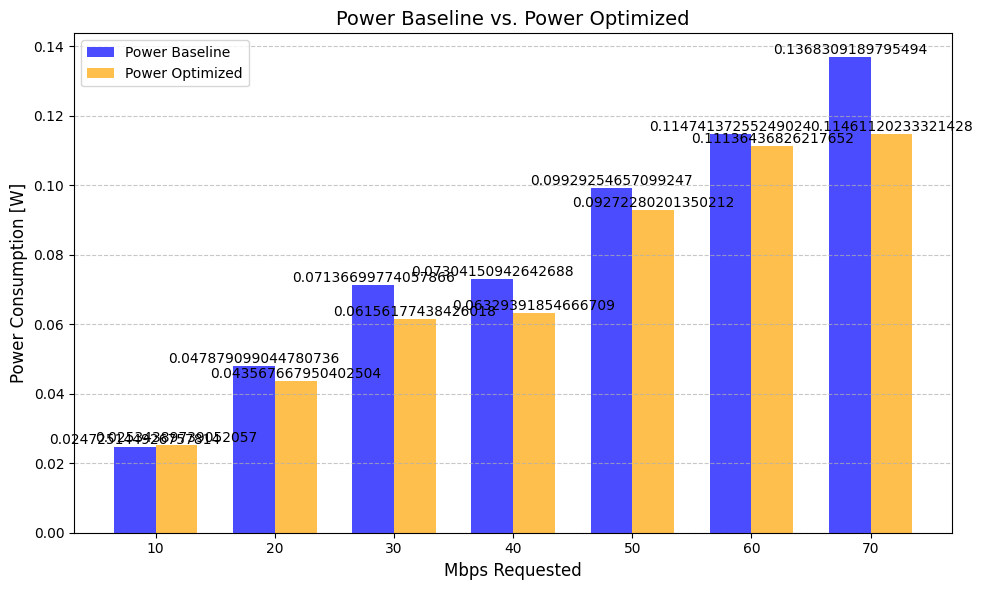

In [36]:
# Plot Power Baseline vs. Power Optimized
fig, ax = plt.subplots(figsize=(10, 6))

# Bar positions for grouping
bar_width = 0.35
positions = range(len(df_comparison['Mbps requested']))

# Plot the baseline and optimized power
baseline_bars = ax.bar(
    positions,
    df_comparison['Power Baseline [W]'],
    width=bar_width,
    label='Power Baseline',
    color='blue',
    alpha=0.7
)
optimized_bars = ax.bar(
    [p + bar_width for p in positions],
    df_comparison['Power Optimized [W]'],
    width=bar_width,
    label='Power Optimized',
    color='orange',
    alpha=0.7
)

# Add values on top of the bars
for bar in baseline_bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),  # Use full precision
        ha='center',
        va='bottom',
        fontsize=10
    )

for bar in optimized_bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),  # Use full precision
        ha='center',
        va='bottom',
        fontsize=10
    )

# Add labels and formatting
ax.set_title('Power Baseline vs. Power Optimized', fontsize=14)
ax.set_xlabel('Mbps Requested', fontsize=12)
ax.set_ylabel('Power Consumption [W]', fontsize=12)
ax.set_xticks([p + bar_width / 2 for p in positions])  # Center the tick labels
ax.set_xticklabels(df_comparison['Mbps requested'])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


# Debug

In [33]:
# Path to the JSON file
file_path = '/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/test_automation/baseline_metrics/metrics_energy.json'
file_path = '/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/test_automation/exp7/70_100_700_500mi_at_cu/metrics_energy.json'
# Load JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

# Filter for entries where cmdline contains "cu.conf"
filtered_data = {}
for process_id, metrics in data.items():
    if any("nr-ue.conf" in metric['cmdline'] for metric in metrics):
        filtered_data[process_id] = metrics

# Process power consumption data
# Collect timestamps and values for CU container
timestamps = []
values = []
for pod_data in filtered_data.values():
    for entry in pod_data:
        timestamps.append(entry['timestamp'])
        values.append(entry['value'])

# Convert timestamps to a relative time from start
start_time = min(timestamps)
end_time = max(timestamps)
filtered_values = [
    value for ts, value in zip(timestamps, values) 
    if (ts - start_time > 0) and (end_time - ts > 0)  # Exclude first and last 20 seconds
]


# Plot the filtered data
plt.figure(figsize=(12, 6))

for process_id, metrics in filtered_data.items():
    timestamps = range(0,len(filtered_values))
    values = filtered_values
    cmdline = next(metric['cmdline'] for metric in metrics if "nr-ue.conf" in metric['cmdline'])
    plt.plot(timestamps, values, marker='o', label=f"{cmdline} ({process_id})")

# Add labels, title, legend, and grid
plt.xlabel("Time")
plt.ylabel("Energy (units)")
plt.title("Energy Consumption Over Time (Processes with 'cu.conf')")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/test_automation/exp7/70_100_700_500mi_at_cu/metrics_energy.json'

In [ ]:
# Filter rows where any of the columns have NaN or 0.00 values
df_show_filtered = df[df.isna().any(axis=1) | (df == 0.00).any(axis=1)]

# Display the rows with NaN or 0.00 values
# df_show_filtered['cpu limit at cu'].str.replace('mi', '').astype(int).unique()
df_show_filtered['Mbps requested'].unique()

array([], dtype=int64)